<a href="https://colab.research.google.com/github/pramodya99/Bearing-Fault-Prediction---CNN/blob/main/Sample_Model_For_Predict_Bearing_Failures_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.0800 - loss: 437.7939
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 695ms/step - accuracy: 0.2000 - loss: 370.2255
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 879ms/step - accuracy: 0.2000 - loss: 630.4240
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.2400 - loss: 355.7469
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.0400 - loss: 165.7219
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.2400 - loss: 210.6244
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.4000 - loss: 118.5220
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 891ms/step - accuracy: 0.1600 - loss: 243.0217
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 670ms/step - accuracy: 0.2800 - loss: 172.3160
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 644ms/step - accuracy: 0.3600 - loss: 75.8365
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 669ms/step - accuracy: 0.2400 - loss: 124.9968
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.1200 -

Test Accuracy: 72.00%


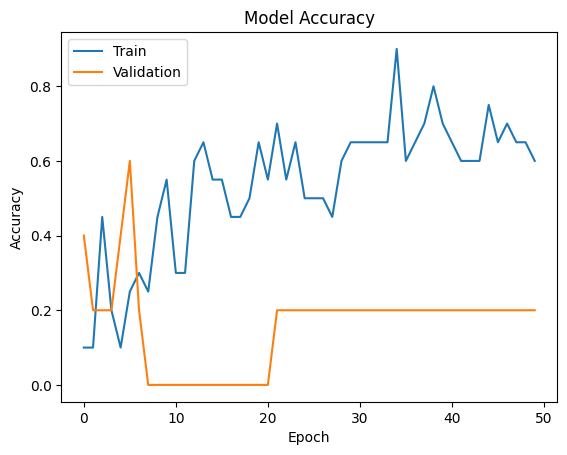

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
Predicted Fault Type: Cage_Fault


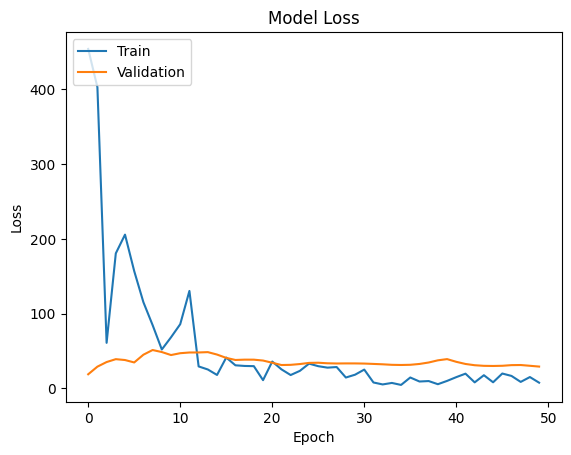

In [55]:
import os
import numpy as np
import pandas as pd
import scipy.signal as signal
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, Concatenate
from tensorflow.keras.models import Model
from scipy import stats
import matplotlib.pyplot as plt

# Define your sampling rate
sample_rate = 42000# Sampling rate in Hz

# Load acceleration data from a CSV file
def load_acceleration_data(file_path, column_name='Accelerometer'):
    df = pd.read_csv(file_path)
    if column_name in df.columns:
        return df[column_name].values
    else:
        raise ValueError(f"Column '{column_name}' not found in the CSV file.")

# Generate spectrogram from the data

def generate_spectrogram(data, sample_rate, nperseg=256, noverlap=128):
    frequencies, times, spectrogram = signal.stft(data, fs=sample_rate, nperseg=nperseg, noverlap=noverlap)
    return np.abs(spectrogram), frequencies, times

# Resize spectrogram for CNN input
def prepare_spectrogram_for_cnn(spectrogram, target_size=(128, 128)):
    # Ensure spectrogram is resized correctly
    return np.resize(spectrogram, target_size)

# Extract statistical features from the time-domain signal

def extract_statistical_features(signal_data):
    mean = np.mean(signal_data)
    std_dev = np.std(signal_data)
    skewness = stats.skew(signal_data)
    kurtosis = stats.kurtosis(signal_data)
    rms = np.sqrt(np.mean(np.square(signal_data)))
    peak = np.max(signal_data)
    variance = np.var(signal_data)
    crest_factor = peak / rms if rms != 0 else 0

    return np.array([mean, std_dev, skewness, kurtosis, rms, peak, crest_factor, variance])

# Function to prepare data and labels for training

def prepare_data(spectrograms, statistical_features, labels, img_size):
    X_cnn = np.array(spectrograms)
    X_cnn = np.expand_dims(X_cnn, axis=-1)  # Add channel dimension for CNN
    X_stat = np.array(statistical_features)
    y = np.array(labels)

    # Encode labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    return [X_cnn, X_stat], y_encoded, label_encoder

# Function to build multi-input model

def build_multi_input_model(input_shape_cnn, input_shape_stat):
    # CNN Input
    cnn_input = Input(shape=input_shape_cnn)
    x = Conv2D(32, (3, 3), activation='relu')(cnn_input)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = Flatten()(x)
    cnn_out = Dense(64, activation='relu')(x)

    # Statistical Features Input
    stat_input = Input(shape=input_shape_stat)
    y = Dense(32, activation='relu')(stat_input)

    # Combine CNN and Statistical features
    combined = Concatenate()([cnn_out, y])
    combined = Dense(64, activation='relu')(combined)
    combined = Dropout(0.5)(combined)
    output = Dense(5, activation='softmax')(combined)  # 5 output classes

    model = Model(inputs=[cnn_input, stat_input], outputs=output)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

# Paths and labels
file_paths = ['/content/BSF', '/content/OUTER', '/content/INNER', '/content/FTF', '/content/NORMAL']  # Update these paths
labels = ['BSF', 'outer_race_fault', 'inner_race_fault', 'Cage_Fault', 'Normal_Bearing']                       # Update labels based on the folder structure

spectrograms = []
statistical_features = []
spectrogram_labels = []

# Process each file and generate spectrograms and statistical features
for label, folder in zip(labels, file_paths):
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        if file_path.endswith('.csv'):
            # Load the acceleration data
            acceleration_data = load_acceleration_data(file_path)

            # Generate the spectrogram
            spectrogram, _, _ = generate_spectrogram(acceleration_data, sample_rate)

            # Resize the spectrogram for CNN input
            spectrogram_resized = prepare_spectrogram_for_cnn(spectrogram)

            # Extract statistical features
            stats_features = extract_statistical_features(acceleration_data)

            # Append the resized spectrogram, statistical features, and label
            spectrograms.append(spectrogram_resized)
            statistical_features.append(stats_features)
            spectrogram_labels.append(label)

# Prepare data and labels for training
img_size = (128, 128)
X, y, label_encoder = prepare_data(spectrograms, statistical_features, spectrogram_labels, img_size)

# Define input shapes
input_shape_cnn = (img_size[0], img_size[1], 1)
input_shape_stat = (8,)  # Updated to reflect the number of statistical features

# Train the multi-input model
multi_input_model = build_multi_input_model(input_shape_cnn, input_shape_stat)
multi_input_model.fit(X, y, epochs=50, batch_size=32)

test_loss, test_accuracy = multi_input_model.evaluate(X, y)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

# Save the trained model
multi_input_model.save('multi_input_bearing_fault_model.h5')

# Plot training & validation accuracy

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt

# Load the trained model for predictions
model = tf.keras.models.load_model('multi_input_bearing_fault_model.h5')

# Predict fault type on new acceleration data
new_file_path = '/content/C_17_1.csv'  # Replace with actual path
new_acceleration_data = load_acceleration_data(new_file_path)

# Generate spectrogram
new_spectrogram, _, _ = generate_spectrogram(new_acceleration_data, sample_rate)
new_spectrogram_resized = prepare_spectrogram_for_cnn(new_spectrogram)

# Extract statistical features
new_stats = extract_statistical_features(new_acceleration_data)

# Prepare inputs for prediction
new_spectrogram_input = np.expand_dims(new_spectrogram_resized, axis=0)
new_stat_input = np.expand_dims(new_stats, axis=0)

# Predict the fault type
prediction = model.predict([new_spectrogram_input, new_stat_input])
predicted_class = np.argmax(prediction)
fault_type = label_encoder.inverse_transform([predicted_class])

print(f'Predicted Fault Type: {fault_type[0]}')

